# Udacity Self Driving Car Nanodegegree
## Term 1. Project 4 - Advanced Lane Finding 

Lane finding is an important component of self-driving cars, the goal of the project is to identify the lane boundaries in a video from a front-facing camera on a car. The algorithm uses advanced computer vision techniques to detect lanes, locate the car between two lanes and estimate curvature of the road and the vehicle's position relative to the center of the lane.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import math
# import libraries needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from matplotlib import gridspec
% matplotlib inline
#import warnings
#warnings.filterwarnings('ignore')

## Calibrate camera
Computation of camera calibration matrix and distortion coefficients using a set of chessboard images.

In [2]:
# use glob to obtain list of calibration images names
cal_images_names = glob.glob('./camera_cal/calibration*.jpg')

In [3]:
print(cal_images_names)

['./camera_cal/calibration5.jpg', './camera_cal/calibration4.jpg', './camera_cal/calibration6.jpg', './camera_cal/calibration7.jpg', './camera_cal/calibration3.jpg', './camera_cal/calibration2.jpg', './camera_cal/calibration1.jpg', './camera_cal/calibration20.jpg', './camera_cal/calibration19.jpg', './camera_cal/calibration18.jpg', './camera_cal/calibration15.jpg', './camera_cal/calibration14.jpg', './camera_cal/calibration16.jpg', './camera_cal/calibration17.jpg', './camera_cal/calibration13.jpg', './camera_cal/calibration12.jpg', './camera_cal/calibration10.jpg', './camera_cal/calibration11.jpg', './camera_cal/calibration9.jpg', './camera_cal/calibration8.jpg']


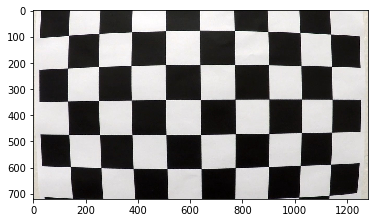

In [4]:
# show an example of calibraiton image
cal_image = mpimg.imread('./camera_cal/calibration1.jpg')
plt.imshow(cal_image)

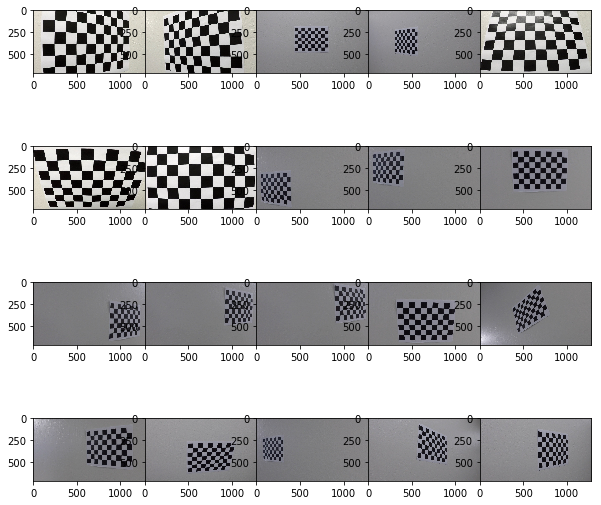

In [5]:
# Visualize calibration boards
grid_spec = gridspec.GridSpec(4,5)
fig = plt.figure(figsize = (10,10))
for i in range(4):
    for j in range(5):
        plt.subplot(grid_spec[i,j])
        cal_image = mpimg.imread(cal_images_names[i*5+j])
        plt.imshow(cal_image)
plt.subplots_adjust(wspace=0, hspace=0)

In [6]:
# calibrates camera based on a set of images of calibration chessboard
# nx and ny - number of internal cornes along respective axis

def calibrate_camera(cal_images_names, nx, ny):
    # arrays to store objects and image points from all the images
    objpoints = [] # 3D points in real world space (object points)
    imgpoints = [] #2D points in image space (image points)
    cal_images_with_corners = [] # list to store calibration images with located corners
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0)....(8,5,0)
    objp = np.zeros ((9*6,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    # go through images and find Chessboard corners
    for idx, cal_img_name in enumerate(cal_images_names):
        cal_img = cv2.imread(cal_img_name)
        # convert to grayscale
        gray = cv2.cvtColor(cal_img, cv2.COLOR_BGR2GRAY) # use BGR2GRAY here as images were read by glob API
        # find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        if ret == True:
            print('working on ', cal_img_name)
            imgpoints.append(corners)
            objpoints.append(objp) # same for all calibration images as it represents real chessboard
            # draw and display the corners
            cv2.drawChessboardCorners(cal_img, (9,6), corners, ret)
            cal_images_with_corners.append(cal_img)
            write_name = 'corners_found' + str(idx) + '.jpg'
            cv2.imwrite(write_name,cal_images_with_corners[-1])
    # calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)  
    # return calibration results (calibration matrix and distortion coefficients) and list of images with located corners
    return mtx, dist, cal_images_with_corners       

In [7]:
nx, ny = 9, 6
mtx, dist, images_with_corners = calibrate_camera(cal_images_names, nx, ny)
# NB 17 out of 20 images were used for calibraiton - 3 were not of great quality (e.g. not full 9x6 corners)

working on  ./camera_cal/calibration6.jpg
working on  ./camera_cal/calibration7.jpg
working on  ./camera_cal/calibration3.jpg
working on  ./camera_cal/calibration2.jpg
working on  ./camera_cal/calibration20.jpg
working on  ./camera_cal/calibration19.jpg
working on  ./camera_cal/calibration18.jpg
working on  ./camera_cal/calibration15.jpg
working on  ./camera_cal/calibration14.jpg
working on  ./camera_cal/calibration16.jpg
working on  ./camera_cal/calibration17.jpg
working on  ./camera_cal/calibration13.jpg
working on  ./camera_cal/calibration12.jpg
working on  ./camera_cal/calibration10.jpg
working on  ./camera_cal/calibration11.jpg
working on  ./camera_cal/calibration9.jpg
working on  ./camera_cal/calibration8.jpg


In [8]:
# Save camera calibration results for later use
dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
pickle.dump(dist_pickle, open('./calibration_pickle.p', 'wb'))

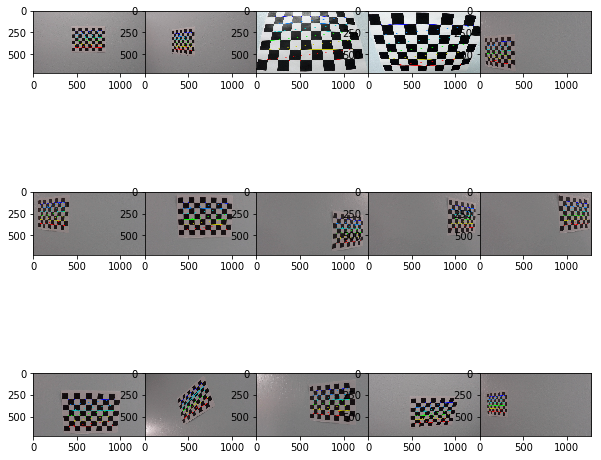

In [9]:
# Visualize 15 calibration chessboard images with found corners
grid_spec = gridspec.GridSpec(3,5)
fig = plt.figure(figsize = (10,10))

for i in range(3):
    for j in range(5):
        plt.subplot(grid_spec[i,j])
        plt.imshow(images_with_corners[i*5 + j])
plt.subplots_adjust(wspace=0, hspace=0)

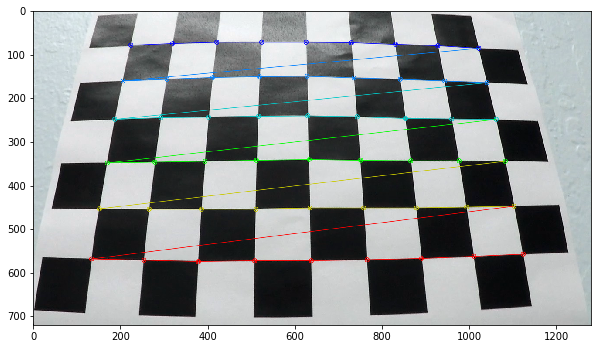

In [10]:
#check that corners have been located correctly
fig = plt.figure(figsize = (10,10))
plt.imshow(images_with_corners[2])

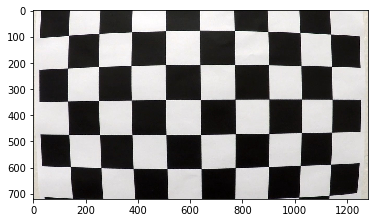

In [11]:
# let's undistort a chess board
dist_chessboard = mpimg.imread('./camera_cal/calibration1.jpg')
plt.imshow(dist_chessboard)

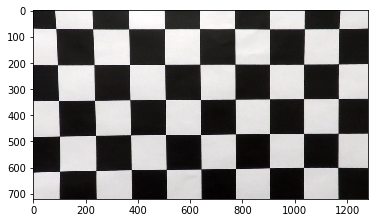

In [12]:
undist_chessboard = cv2.undistort(dist_chessboard, mtx, dist, None, mtx)
plt.imshow(undist_chessboard)

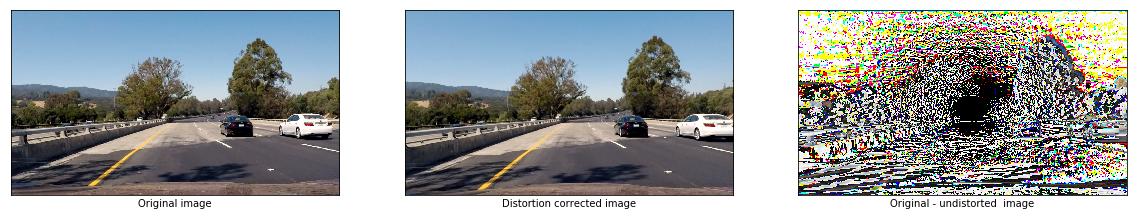

In [13]:
# let's take a distorted image and undistort it
image = mpimg.imread('test_images/test4.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)
# plot original and undistorted images
plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.xlabel('Original image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1, 3, 2)
plt.imshow(undist)
plt.xlabel('Distortion corrected image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1, 3, 3)
plt.imshow(image-undist)
plt.xlabel('Original - undistorted  image')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [14]:
# Read in camera calibration matrix and distortion parameters
dist_pickle = pickle.load(open('camera_cal/calibration_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

## Auxiliary functions & classes

In [15]:
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height), \
                max(0,int(center-width)):min(int(center+width),img_ref.shape[1])] = 1
    return output

In [16]:
# when starting a new instance of the class tracker() please specify all unassigned variables
# core code from Udacity
class tracker():
    def __init__(self, Mywindow_width, Mywindow_height, Mymargin, My_ym = 1, My_xm = 1, Mysmooth_factor = 15):
        # list storing all the past (left, right) center set values - used for smoothing the output
        self.recent_centers = []
        
        # the pixel width of the center values, used to count pixels inside centered windows to determines curve values
        self.window_width = Mywindow_width
        
        # the pixel height of the center values, used to count pixels inside centered windows to determines curve values
        self.window_height = Mywindow_height
        
        # the pixel distance in both directions to slide template for searching
        self.margin = Mymargin
        
        self.ym_per_pix = My_ym # meters per pixel in vertical axis
        self.xm_per_pix = My_xm # meters per pixel in horizontal axis
        
        self.smooth_factor = Mysmooth_factor
        
    def find_window_centroids(self, warped):
        window_width = self.window_width
        window_height = self.window_height
        margin = self.margin
        
        window_centroids = [] # store the (left, right) window centroid positions per level
        window = np.ones(window_width) # create window template to be used for convolutions
        
        # first find the left and right positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template
        
        l_sum = np.sum(warped[int(3*warped.shape[0]/4):,  :int(warped.shape[1]/2)], axis = 0)
        l_center = np.argmax(np.convolve(window, l_sum)) - window_width/2
        r_sum = np.sum(warped[int(3*warped.shape[0]/4):,  int(warped.shape[1]/2):], axis = 0)
        r_center = np.argmax(np.convolve(window, l_sum)) - window_width/2 + int(warped.shape[1]/2)
            
        # add what we found fot the first layer
        window_centroids.append((l_center, r_center))
        
        # go thought each layer to detect pixel locations
        for level in range(1,(int)(warped.shape[0] / window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis = 0)
            conv_signal = np.convolve(window, image_layer)
        
            # find the best left centroid by using past left center as a reference
            # use window_width/2 as offset because convolutional signal reference is at rigth side of window, not centre of window
            offset = window_width/2
            l_min_index = int(max(l_center + offset - margin,0))
            l_max_index = int(min(l_center + offset + margin, warped.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+ l_min_index - offset
            # find the best right centroid by usin past right centre as a reference
            r_min_index = int(max(r_center + offset - margin,0))
            r_max_index = int(min(r_center + offset + margin, warped.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+ r_min_index - offset
            # add what we found for that layer
            window_centroids.append((l_center, r_center))
        
            self.recent_centers.append(window_centroids)
            # return aggregated values of the line, helps to keep the markers from jumping around too much
        return np.average(self.recent_centers[-self.smooth_factor:], axis = 0)

## Apply Perspective Transform

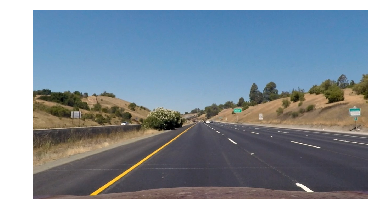

In [17]:
# Apply Perspective Transform to undistorted camera image to get a bird view of the road
img = mpimg.imread('test_images/straight_lines1.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx);
plt.imshow(img)
plt.axis('off');

In [18]:
img_size = (img.shape[1], img.shape[0])
p1_x1, p1_y1 = 200, 720
length, p1_angle1  = 420, 34
p1_x2 = p1_x1 + length * math.cos(p1_angle1 * math.pi / 180)
p1_y2 = p1_y1 - length * math.sin(p1_angle1 * math.pi / 180)

In [19]:
p2_x1, p2_y1 = 1100, 720
p2_angle2  = 34
p2_x2 = p2_x1 - length * math.cos(p2_angle2 * math.pi / 180)
p2_y2 = p2_y1 - length * math.sin(p2_angle2 * math.pi / 180)

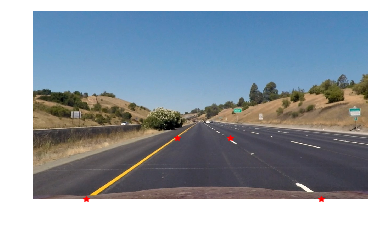

In [20]:
plt.imshow(img)
plt.axis('off');
#plt.plot([x1, x2], [y1, y2], color='k', linestyle='-', linewidth=2)
plt.plot(p1_x1,p1_y1, '*', color = 'r')
plt.plot(p1_x2,p1_y2, '*', color = 'r')
plt.plot(p2_x1,p2_y1, '*', color = 'r')
plt.plot(p2_x2,p2_y2, '*', color = 'r')
plt.show()

In [21]:
# compute Perspective Transform
offset = img_size[0] * 0.25
src = np.float32([[p2_x2,p2_y2],[p2_x1,p2_y1], [p1_x1,p1_y1],[p1_x2,p1_y2]])
dst = np.float32([[img.shape[1]-offset,img.shape[0]-length], [img.shape[1]-offset,img.shape[0]],\
       [offset, img.shape[0]], [offset,img.shape[0]-length]])
M = cv2.getPerspectiveTransform(src,dst) # compute the perspective tranform M
Minv = cv2.getPerspectiveTransform(dst, src) # compute the inverse perspective transfom Minv
warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]))

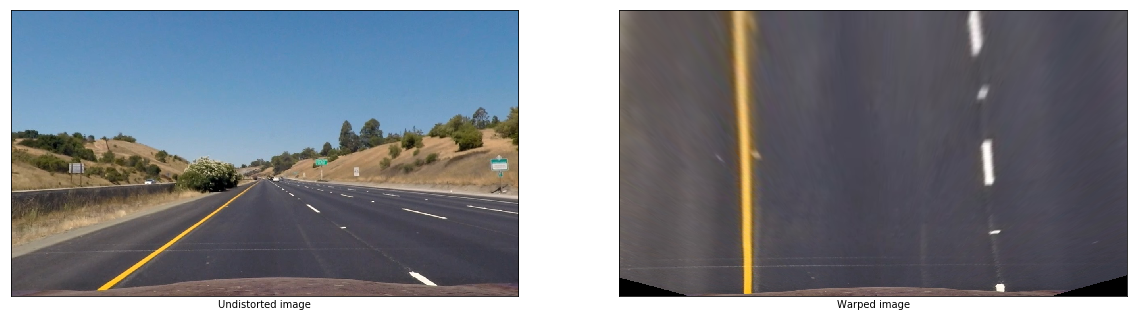

In [22]:
# plot undistorted and warped  images
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.xlabel('Undistorted image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1, 2, 2)
plt.imshow(warped)
plt.xlabel('Warped image')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [23]:
# back to curved lanes - let's take an image, indistort it and warp it
image = mpimg.imread('test_images/test2.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)
warped = cv2.warpPerspective(undist, M, (image.shape[1],image.shape[0]))

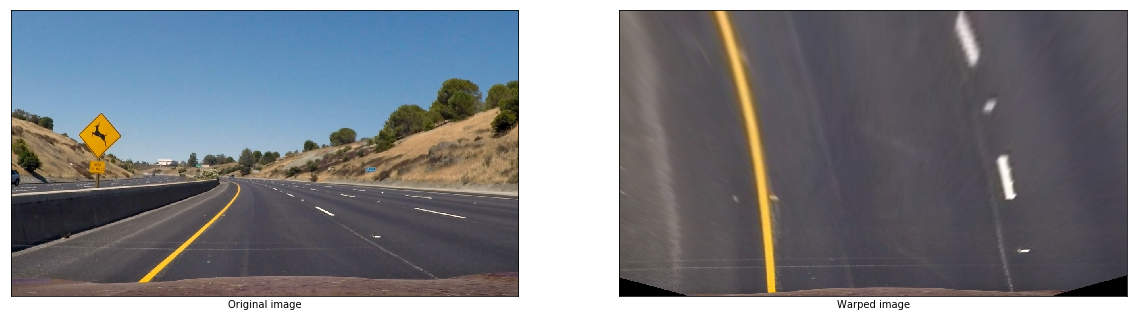

In [24]:
# plot original and warped  images
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.xlabel('Original image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1, 2, 2)
plt.imshow(warped)
plt.xlabel('Warped image')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

## Color thresholding

In [25]:
# apply color threshold
def color_threshold(img, sthresh = (0,255), vthresh = (0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1
    
    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] = 1
    return output

In [26]:
# apply threshold to x or y Sobel gradients
def abs_sobel_thresh(img, orient='x', sobel_kernel=15, thresh = (0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Apply threhold
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

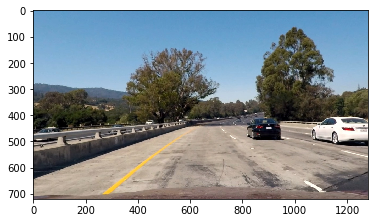

In [27]:
img = cv2.imread('./test_images/test1.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

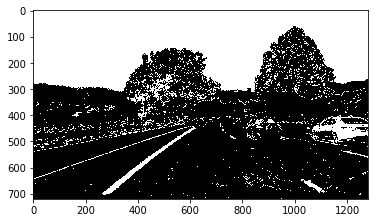

In [28]:
combined = np.zeros_like(img[:,:,0])
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh = (12, 255))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh = (25, 255))
color_binary = color_threshold(img, sthresh = (100,255), vthresh = (50,255))
combined[((gradx == 1) & (grady == 1) | (color_binary == 1))] = 255
plt.imshow(combined, cmap = 'gray')    

## Preprocessing

In [29]:
# core code from Udacity
images = glob.glob('./test_images/test*.jpg')
preprocessed_images = []
masked_images = []

for idx, fname in enumerate(images):
    # read an image
    img = cv2.imread(fname)
    # undistort the image
    img = cv2.undistort(img, mtx, dist, None, mtx)
    # process images and generate binary mask
    combined = np.zeros_like(undist[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh = (12, 255))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh = (25, 255))
    color_binary = color_threshold(img, sthresh = (100,255), vthresh = (50,255))
    combined[((gradx == 1) & (grady == 1) | (color_binary == 1))] = 255
    masked_images.append(combined)
    warped = cv2.warpPerspective(combined, M, (combined.shape[1],combined.shape[0]))
    preprocessed_images.append(warped)
    
    window_width = 25
    window_height = 80
    
    curve_centers = tracker(Mywindow_width = window_width, Mywindow_height = window_height, Mymargin = 25,\
                            My_ym = 32/720, My_xm = 3.7/900, Mysmooth_factor = 15)
    window_centroids = curve_centers.find_window_centroids(warped)
    
    # points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
    
    # points used to find the left and rights lanes
    rightx =[]
    leftx =[]
    
    # go through each level and draw the windows
    for level in range(0,len(window_centroids)):
        # window mask is a function to draw window areas
        # add center value found in frame to the list of lane points per left, right
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        l_mask = window_mask(window_width, window_height, warped, window_centroids[level][0], level)
        r_mask = window_mask(window_width, window_height, warped, window_centroids[level][1], level)
        # add graphic points from window mask here to total pixels found
        l_points[(l_points == 255) | (l_mask == 1)] = 255
        r_points[(r_points == 255) | (r_mask == 1)] = 255
    
    template = np.array(r_points + l_points, np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel, template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped, warped, warped)), np.uint8) # make original road pixels 3 color channel
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the original road image with window results
    
    # fit the lane boundaries to the left, right and center positions found
    yvals = range(0, warped.shape[0])
    
    res_yvals = np.arange(warped.shape[0]-(window_height/2),0, -window_height)
    
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0] * yvals * yvals + left_fit[1] * yvals + left_fit[2]
    left_fitx = np.array(left_fitx, np.int32)
    
    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0] * yvals * yvals + right_fit[1] * yvals + right_fit[2]
    right_fitx = np.array(right_fitx, np.int32)
    
    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2), axis = 0), np.concatenate((yvals,yvals[::-1]), axis = 0))), np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2), axis = 0), np.concatenate((yvals,yvals[::-1]), axis = 0))), np.int32)
    inner_lane = np.array(list(zip(np.concatenate((left_fitx+window_width/2, right_fitx[::-1]-window_width/2), axis = 0), np.concatenate((yvals,yvals[::-1]), axis = 0))), np.int32)
    
    road = np.zeros_like(img)
    road_bkg = np.zeros_like(img)
    cv2.fillPoly(road, [left_lane], color = [255,0,0])
    cv2.fillPoly(road, [right_lane], color = [0,0,255])
    cv2.fillPoly(road, [inner_lane], color = [0,255,0])
    cv2.fillPoly(road_bkg, [left_lane], color = [255,255,255])
    cv2.fillPoly(road_bkg, [right_lane], color = [255,255,255])
    
    road_warped =cv2.warpPerspective(road, Minv, img_size)
    road_warped_bkg =cv2.warpPerspective(road_bkg, Minv, img_size)
    
    base = cv2.addWeighted(img, 1.0, road_warped_bkg, -1.0, 0.0)
    result = cv2.addWeighted(base, 1.0, road_warped, 0.7, 0.0)
    
    ym_per_pix = curve_centers.ym_per_pix # meters per pixels
    xm_per_pix = curve_centers.xm_per_pix # meters per pixels
    
    curve_fit_cr = np.polyfit(np.array(res_yvals, np.float32)*ym_per_pix, np.array(leftx,np.float32)*xm_per_pix,2)
    curverad = ((1 + (2*curve_fit_cr[0]*yvals[-1]*ym_per_pix + curve_fit_cr[1]**2)**1.5))/ np.absolute(2*curve_fit_cr[0])
                
    # calculate the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[-1]) / 2
    center_diff = (camera_center - warped.shape[1]/2) * xm_per_pix
    
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'

    cv2.putText(result, 'Radius of Curvature =', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    cv2.putText(result, 'Vehicle is ' + str(round(center_diff, 3)) + '(m) ' + side_pos + ' of center', (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    
    if not (math.isnan(curverad)):
        cv2.putText(result, str(round(curverad, 3)) + '(m)', (425,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
   
    
    write_name = './test_images/tracked' + str(idx) +'.jpg'
    cv2.imwrite(write_name, result)

## Visualize preprocessed images

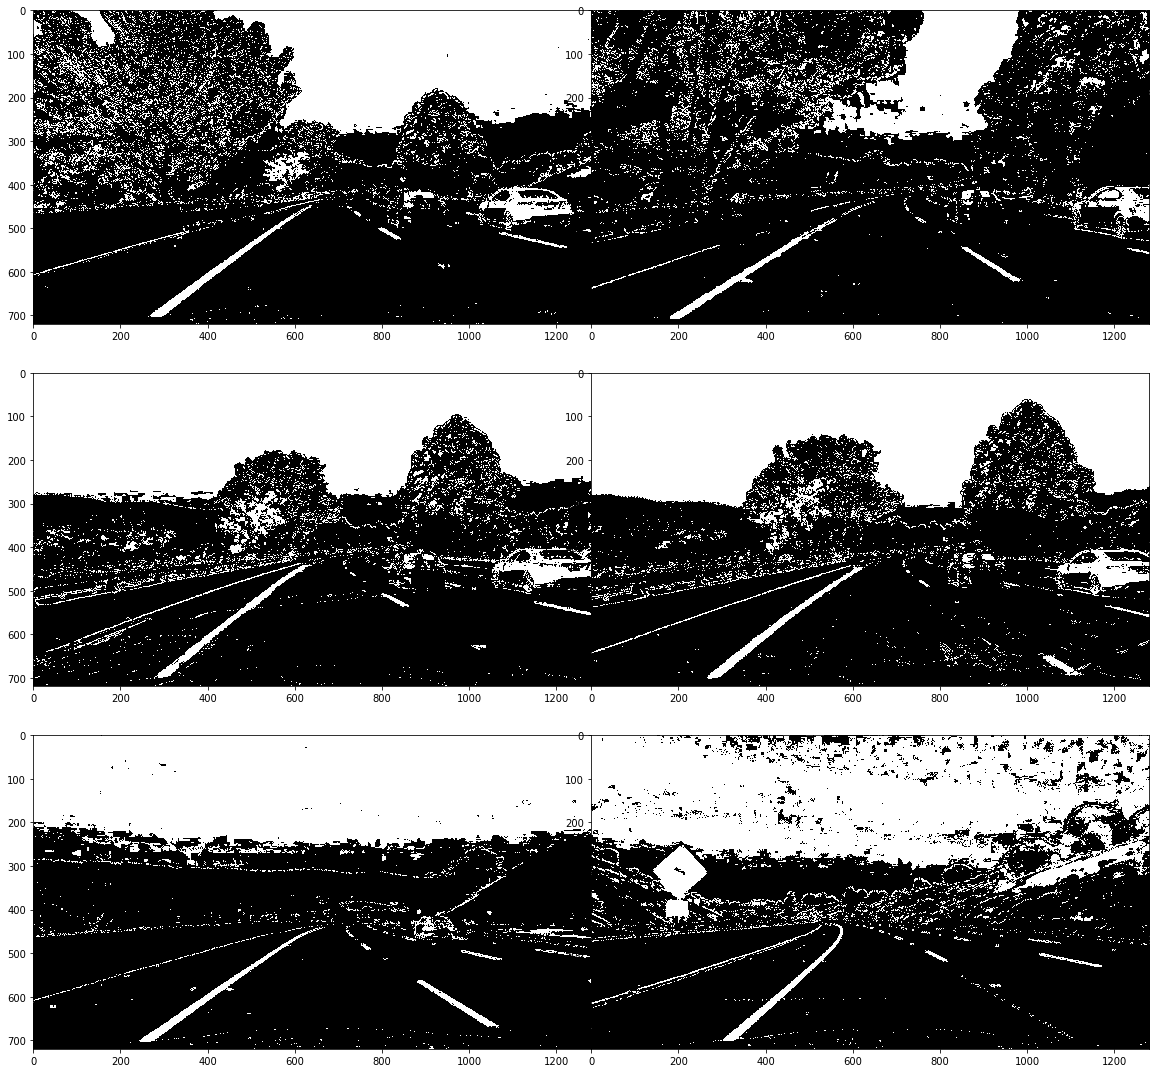

In [30]:
# Visualize 6 preprocessed (after Sobel and color masks) test images
grid_spec = gridspec.GridSpec(3,2)
fig = plt.figure(figsize = (20,20))

for i in range(3):
    for j in range(2):
        plt.subplot(grid_spec[i,j])
        plt.imshow(masked_images[i*2+j], cmap = 'gray')
plt.subplots_adjust(wspace=0, hspace=0)

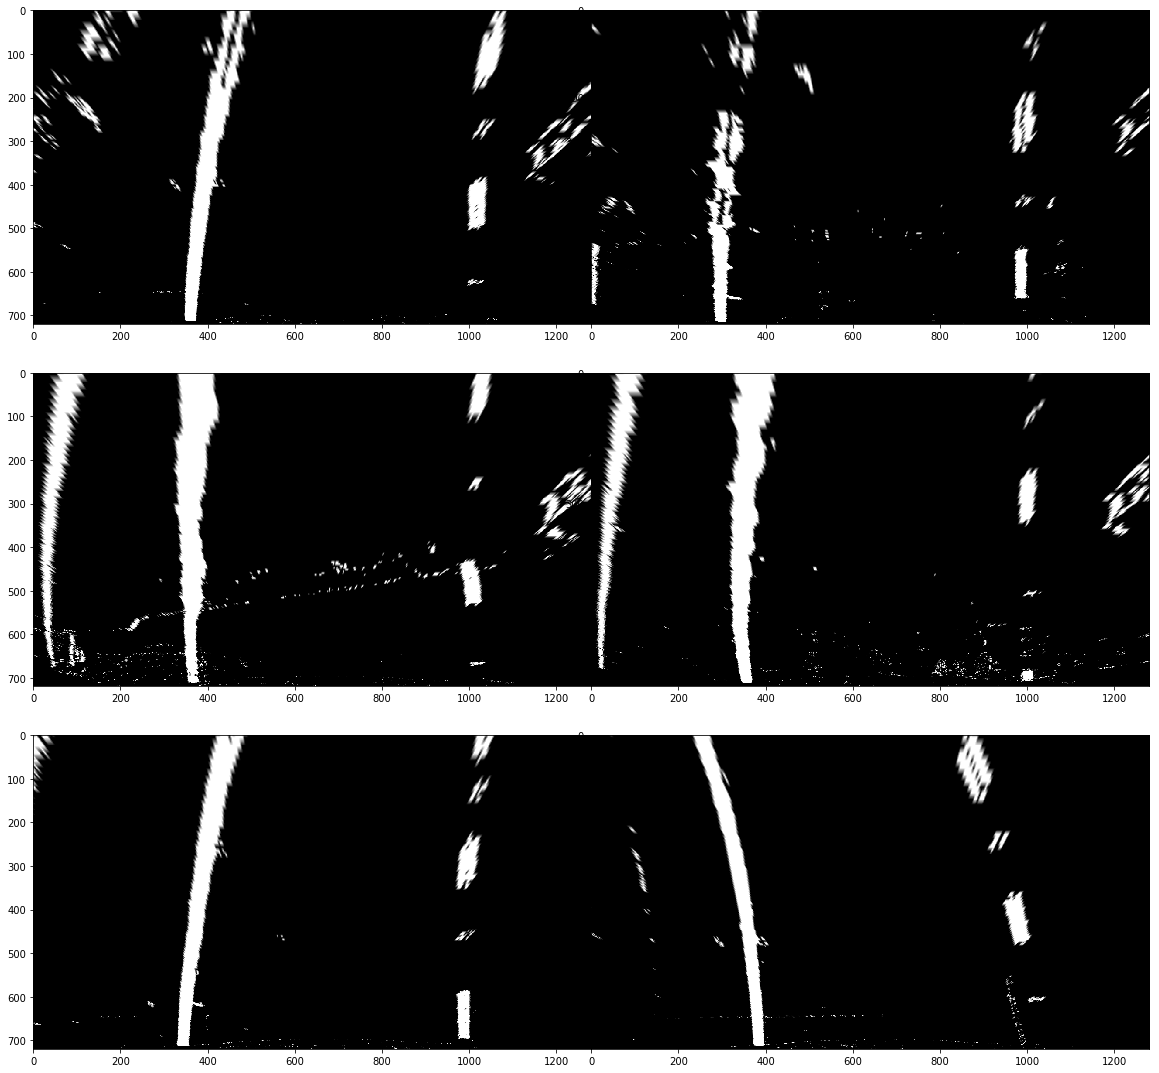

In [31]:
# Visualize 6 preprocessed (after Perspective Transform) test images
grid_spec = gridspec.GridSpec(3,2)
fig = plt.figure(figsize = (20,20))

for i in range(3):
    for j in range(2):
        plt.subplot(grid_spec[i,j])
        plt.imshow(preprocessed_images[i*2+j], cmap = 'gray')
plt.subplots_adjust(wspace=0, hspace=0)

## Video pipeline

In [32]:
# read the saved objpoints and imgpoints
dist_pickle = pickle.load(open('camera_cal/calibration_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

In [33]:
previous_curverad = float('inf')
first_frame = True

# core code from Udacity Q&A

def process_image(img):
    
    global previous_curverad
    global previous_left_fitx
    global previous_right_fitx
    global first_frame
    
    img = cv2.undistort(img, mtx, dist, None, mtx)
    # process images and generate binary mask
    combined = np.zeros_like(undist[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh = (12, 255))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh = (25, 255))
    color_binary = color_threshold(img, sthresh = (100,255), vthresh = (50,255))
    combined[((gradx == 1) & (grady == 1) | (color_binary == 1))] = 255
    warped = cv2.warpPerspective(combined, M, (combined.shape[1],combined.shape[0]))
    
    window_width = 25
    window_height = 80
    
    curve_centers = tracker(Mywindow_width = window_width, Mywindow_height = window_height, Mymargin = 25,\
                            My_ym = 32/720, My_xm = 3.7/900, Mysmooth_factor = 15)
    window_centroids = curve_centers.find_window_centroids(warped)
    
    ym_per_pix = curve_centers.ym_per_pix # meters per pixels
    xm_per_pix = curve_centers.xm_per_pix # meters per pixels
    
    # points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
    
    # points used to find the left and rights lanes
    rightx =[]
    leftx =[]
    
    # go through each level and draw the windows
    for level in range(0,len(window_centroids)):
        # window mask is a function to draw window areas
        # add center value found in frame to the list of lane points per left, right
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        l_mask = window_mask(window_width, window_height, warped, window_centroids[level][0], level)
        r_mask = window_mask(window_width, window_height, warped, window_centroids[level][1], level)
        # add graphuc points from window mask here to total pixels found
        l_points[(l_points == 255) | (l_mask == 1)] = 255
        r_points[(r_points == 255) | (r_mask == 1)] = 255
    
    template = np.array(r_points + l_points, np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel, template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped, warped, warped)), np.uint8) # make original road pixels 3 color channel
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the original road image with window results
    
    # fit the lane boundaries to the left, right and center positions found
    yvals = range(0, warped.shape[0])
    
    res_yvals = np.arange(warped.shape[0]-(window_height/2),0, -window_height)
    
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0] * yvals * yvals + left_fit[1] * yvals + left_fit[2]
    left_fitx = np.array(left_fitx, np.int32)
    
    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0] * yvals * yvals + right_fit[1] * yvals + right_fit[2]
    right_fitx = np.array(right_fitx, np.int32)
    
    distance1 = (right_fitx[0] - left_fitx[0]) * xm_per_pix
    distance2 = (right_fitx[-1] - left_fitx[-1]) * xm_per_pix
    distance = abs(distance1 - distance2)
    
    if first_frame:
        previous_left_fitx = left_fitx
        previous_right_fitx = right_fitx
        first_frame = False
    else:
        if (distance > 0.3):
            left_fitx = previous_left_fitx
            right_fitx = previous_right_fitx
        else:
            previous_left_fitx = 0.9 * previous_left_fitx + 0.1 * left_fitx
            previous_right_fitx = 0.9 * previous_right_fitx + 0.1 * right_fitx
            left_fitx = previous_left_fitx
            right_fitx = previous_right_fitx
        
    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2), axis = 0), np.concatenate((yvals,yvals[::-1]), axis = 0))), np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2), axis = 0), np.concatenate((yvals,yvals[::-1]), axis = 0))), np.int32)
    inner_lane = np.array(list(zip(np.concatenate((left_fitx+window_width/2, right_fitx[::-1]-window_width/2), axis = 0), np.concatenate((yvals,yvals[::-1]), axis = 0))), np.int32)
    
    road = np.zeros_like(img)
    road_bkg = np.zeros_like(img)
    cv2.fillPoly(road, [left_lane], color = [255,0,0])
    cv2.fillPoly(road, [right_lane], color = [0,0,255])
    cv2.fillPoly(road, [inner_lane], color = [0,255,0])
    cv2.fillPoly(road_bkg, [left_lane], color = [255,255,255])
    cv2.fillPoly(road_bkg, [right_lane], color = [255,255,255])
    
    road_warped =cv2.warpPerspective(road, Minv, img_size)
    road_warped_bkg =cv2.warpPerspective(road_bkg, Minv, img_size)
    
    base = cv2.addWeighted(img, 1.0, road_warped_bkg, -1.0, 0.0)
    result = cv2.addWeighted(base, 1.0, road_warped, 0.7, 0.0)
     
    curve_fit_cr = np.polyfit(np.array(res_yvals, np.float32)*ym_per_pix, np.array(rightx,np.float32)*xm_per_pix,2)
    curverad = ((1 + (2*curve_fit_cr[0]*yvals[-1]*ym_per_pix + curve_fit_cr[1]**2)**1.5))/ np.absolute(2*curve_fit_cr[0])
                
    # calculate the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[-1]) / 2
    center_diff = (camera_center - warped.shape[1]/2) * xm_per_pix
    
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'
        
    if (math.isnan(curverad) | (curverad > 10000)):
        curverad = previous_curverad
    else:
        previous_curverad = curverad
        
    cv2.putText(result, 'Radius of Curvature =' + str(round(curverad, 3)) + '(m)', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    cv2.putText(result, 'Vehicle is ' + str(round(center_diff, 3)) + '(m) ' + side_pos + ' of center', (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    #cv2.putText(result, 'Distance is ' + str(round(distance, 3)) + '(m) ', (50,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    
    return result

In [34]:
# test pipeline on short video
first_frame = True
Output_video = 'project_video_test_output.mp4'
Input_video = 'project_video.mp4'

clip = VideoFileClip(Input_video)
test_clip = clip.subclip(20,25)
lane_clip = test_clip.fl_image(process_image) # this function expects color images
lane_clip.write_videofile('Output_test_video.mp4', audio = False)

[MoviePy] >>>> Building video Output_test_video.mp4
[MoviePy] Writing video Output_test_video.mp4


 99%|█████████▉| 125/126 [00:18<00:00,  6.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Output_test_video.mp4 



In [35]:
# test pipeline on short video
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('Output_test_video.mp4'))

In [36]:
# test pipeline on full video
first_frame = True
Output_video = 'project_video_output.mp4'
Input_video = 'project_video.mp4'

clip1 = VideoFileClip(Input_video)
video_clip = clip1.fl_image(process_image) # this function expects color images
video_clip.write_videofile(Output_video, audio = False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:01<00:00,  6.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [37]:
# test pipeline on full video
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video_output.mp4'))